In [90]:
import json
import itertools  # itertools.combinations may be useful
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import streamlit as st
# import altair as alt
import pickle


In [49]:
def load_json(input):
    # Opening JSON file
    f = open(input)
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    # Closing file
    f.close() 
    return data

In [50]:
# OBSOLETE
def get_cn(key,input):
    data = load_json(input)
    for i,el in enumerate(data["intervals"]):
        if el['iid']==key:
            return el['y']
        else:
            continue

    return 0

In [51]:
def draw_network(G):
    # Set overall figure size
    fig = plt.figure(figsize=(40,40))
    fig.tight_layout()

    nx.draw_networkx(G)

In [52]:
def draw_network_colors(G):
    input = 'SM12_12.json'
    node_list = list(G.nodes())
    cn = []
    for node in node_list:
        cn.append(get_cn(node,input))

    # df = pd.DataFrame({'nodes':node_list,'copy_number':cn})
    # print(df)

    #nx.set_node_attributes(G, cn, 'cn')

    fig = plt.figure(figsize=(70,10))
    ax = fig.add_subplot(111)

    #cmap = plt.cm.get_cmap('rainbow')
    cmap = plt.cm.coolwarm
    vmin = 0
    vmax = max(cn) #if len(cn)>0 else 0
    # nx.draw(G, pos=nx.spring_layout(G), node_color = cn, vmin=vmin, vmax=vmax, cmap=cmap,with_labels=True)

    pos=nx.get_node_attributes(G,'pos')

    #print(pos)
    print("115,116,117",pos[115],pos[116],pos[117])
    print("452,453,454",pos[452],pos[453],pos[454])
    print("tight ones")
    print("196,197,198",pos[196],pos[197],pos[198])

    # print("positions:")
    # print("pos min/average/max",min([v[0] for k,v in pos.items() if v[0]>1]),
    #                         sum([v[0] for k,v in pos.items() if v[0]>1])/len([v[0] for k,v in pos.items() if v[0]>1]),
    #                         max([v[0] for k,v in pos.items()]))
    xmax = max([v[0] for k,v in pos.items()])
    
    nx.draw_networkx(G, pos, node_shape="s", node_color = cn, node_size=100, font_size=8,
            vmin=vmin, vmax=vmax, cmap=cmap, with_labels=True,
            ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm,fraction=0.046, pad=0.04, aspect=10)#https://matplotlib.org/stable/api/colorbar_api.html

    ax.tick_params(left=True, right=True, top=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_title("The Longest Chain")
    ax.set_ylabel("Copy Number")
    ax.set_xlabel("Starting Position/$10^{9}$")
    #ax.set_xlim(0,xmax*1.01)
    #ax.set_xscale("log")
  

In [53]:
def find_longest_chain(G,df):
    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])

        x0 = 0.0 # start point of prev node

        if max(j.values()) == diameter:

            how_many_longest += 1
            node_list = list(j.keys())
            print("node list and its length:", node_list, len(node_list))

            for n,node in enumerate(node_list):
                x1=int(df[df['Source']==node]['Start Point'])/(10**9)
                x2=int(df[df['Source']==node]['End Point'])/(10**9)
                y=int(df[df['Source']==node]['Copy Number'])
                print(x1)

                # sep = 0.1 if n>1 else 0                  
                
                # Add nodes and connect them                
                G2.add_node(node_list[n],pos=(x1,y))
                if n>0:
                    G2.add_edge(node_list[n-1],node_list[n])


                x0=x1

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2

In [54]:
def getnodeinfo(nodeID,jsonfile):
    # NEEDS ABS VAL OF SOURCE
    # Returns copy number, starpoint, endpoint information
    # from the first part of json file
    # P.S.: returning just el['y'] is the same as get_cn()
    # this returns start and end points of nodes on top of that
    
    data = load_json(jsonfile)

    for i,el in enumerate(data["intervals"]):            
        if el['iid']==nodeID:
            if nodeID==454:
                print("getnodeinfo",el['y'],el['startPoint'],el['endPoint'])
            return el['y'],el['startPoint'],el['endPoint']
        else:
            continue
    
    print("getnodeinfo can't find this")

    return 0

In [55]:
def make_nodes(jsonfile):
    data = load_json(jsonfile)
    # Iterating through the json
    # list
    #_nodegroups = []
    _nodegroups = {}
    for i,el in enumerate(data["connections"]): # out [:100] for test, otherwise all

        nodeID = abs(el['source'])
        
        if el['type']!='LOOSE':

            if getnodeinfo(nodeID,jsonfile)!=0:
                cn,sp,ep = getnodeinfo(nodeID,jsonfile)
                _nodegroups[nodeID] =  [abs(el['sink']),cn,sp,ep] # dict of lists
            else:
                _nodegroups[nodeID] =  [abs(el['sink']),0,0,0]
        else:

            # LOOSE EDGES
            if nodeID in _nodegroups.keys():
                # If the node w/ a Sink is detected, don't overwrite it with a Loose type
                continue
            else:
                # If the node doesn't have a Sink, use it with Loose
                # If its data entry with "sink" comes up later, it will overwrite "loose" version of it
                if getnodeinfo(nodeID,jsonfile)!=0:
                    cn,sp,ep = getnodeinfo(nodeID,jsonfile)
                    _nodegroups[nodeID] =  ['loose',cn,sp,ep] # dict of lists
                else:
                    _nodegroups[nodeID] =  ['loose',0,0,0]
        # print("LOOP",_nodegroups)

    print("make nodes end",_nodegroups[454])
                
    return _nodegroups

In [56]:
def handle_index_column(df):
    df2 = df.rename_axis('Source').reset_index()    
    return df2

In [57]:
def make_df(jsonfile):
    nodedict = make_nodes(jsonfile) # this is a dict of lists
    #  = nodeID(source)| sink | CN(y) | start p | end p
    
    # now turn this into a pandas dataframe
    df = pd.DataFrame.from_dict(nodedict, orient='index')
    
    df.columns =['Sink', 'Copy Number','Start Point', 'End Point']
    
    df2 = handle_index_column(df)
    
    return df2

In [58]:
def make_graph(jsonfile):

    #_nodegroups = make_nodes(input)

    # GET DataFrame here and make nodes
    
    df = make_df(jsonfile) # nodeID(source)| sink | CN(y) | start p | end p
    
    print(df)
    
    G=nx.DiGraph()

    # from DF directly, however it sees nan values as a single node of 'nan'
    # G=nx.from_pandas_edgelist(df, 'Source', 'Sink') 

    # Alternative way
    G.add_edges_from(zip(df['Source'].tolist(),df['Sink'].tolist()))


#     for node in _nodegroups:
#         # node = [source,sink]
#         if len(node)>1:
#             G.add_edge(abs(node[0]),abs(node[1])) # no info of connection to its left or right
#         else:
#             G.add_node(abs(node[0]))

    return G,df

In [59]:
_graph,df = make_graph('SM12_12.json')
#draw_network(_graph)

getnodeinfo 2 248654803 248956422
getnodeinfo 2 248654803 248956422
make nodes end ['loose', 2, 248654803, 248956422]
      Source   Sink  Copy Number  Start Point  End Point
0       1545   1546            7     23820865   23821002
1       1508   1509            8     22132854   22133231
2       1506   1507            7     22111602   22111802
3       1376   1377            6     76152669   76153228
4       1373   1374           30     75632352   75632602
...      ...    ...          ...          ...        ...
3648    3263  loose            2    156155003  159345973
3649    1788  loose            2    106766003  107043718
3650    2102  loose            1     83208603   83257441
3651    2812  loose            1    190184603  190214555
3652    2984  loose            1    170730003  170805979

[3653 rows x 5 columns]


In [60]:
# pickle.dump(df, open('tmp/dataframe.txt', 'wb'))
# df = pickle.load(open('tmp/dataframe.txt','rb'))

In [61]:
df[df['Source']==454]

,Source,Sink,Copy Number,Start Point,End Point
3634,454,loose,2,248654803,248956422


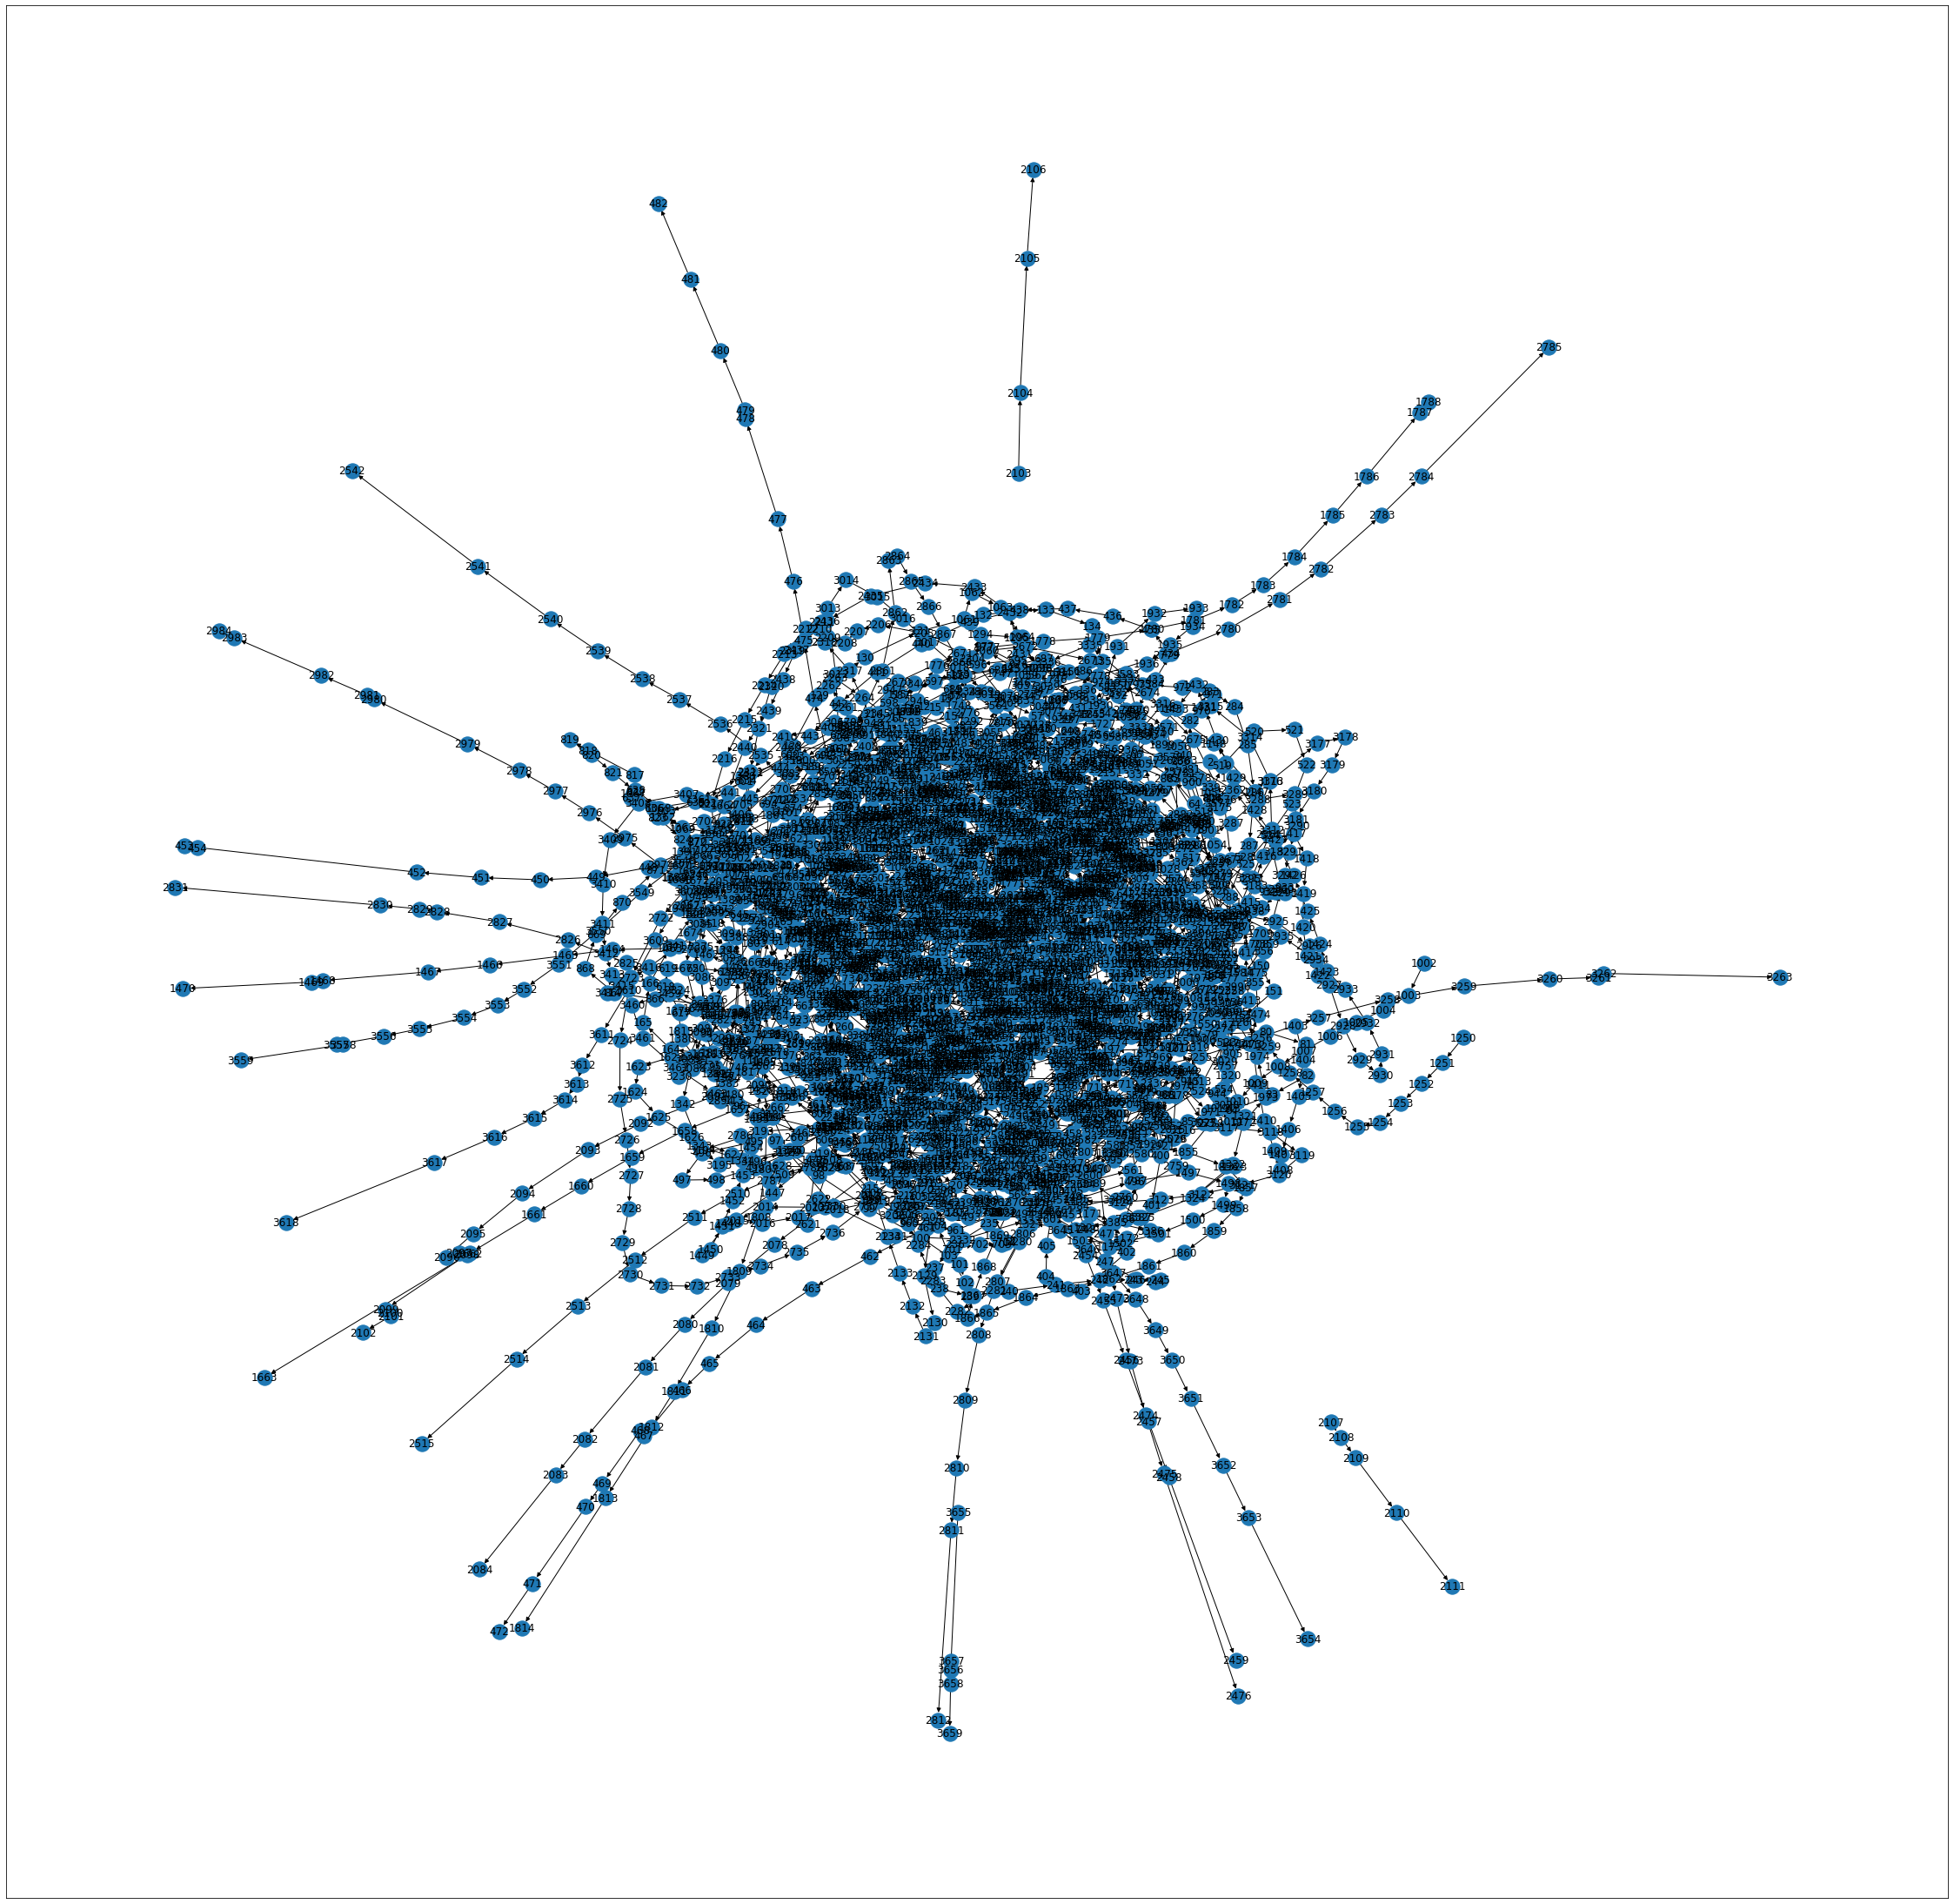

In [62]:
# Obsolete after removing loose links
_graph.remove_node('loose')
draw_network(_graph)

In [63]:
len(list(_graph.nodes(141)))

3658

In [64]:
_graph.edges(3)

OutEdgeDataView([(3, 4)])

## FIND LONGEST CHAIN

the longest is path length is 453
node list and its length: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

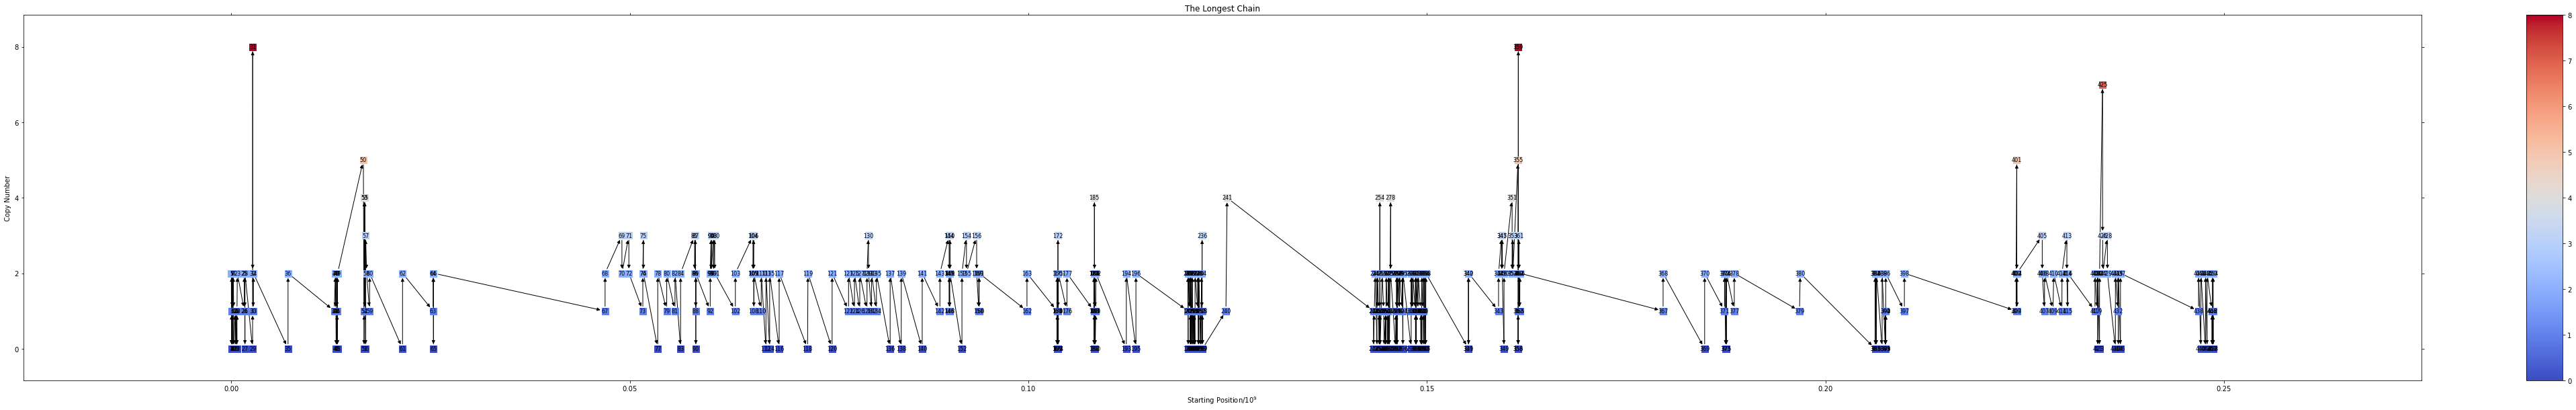

In [65]:
longest_graph = find_longest_chain(_graph,df)
draw_network_colors(longest_graph)

In [91]:
# Dump again or load longest chain faster
# pickle.dump(longest_graph, open('tmp/graph.txt', 'wb'))
# lg = pickle.load(open('tmp/graph.txt','rb'))

## PLOTLY TEST

In [1]:
import plotly.graph_objects as go

In [88]:
edge_x = []
edge_y = []
for edge in lg.edges():
    x0, y0 = lg.nodes[edge[0]]['pos']
    x1, y1 = lg.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = [] # position
node_y = [] # copy number
node_id = [] # node id
for node in lg.nodes():
    x, y = lg.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_id.append(node)

# print(node_x)
# print(node_y)
# print(node_id)
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=y,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Copy Number',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = node_id
node_trace.marker.color = node_y

In [33]:
# node_adjacencies = []
# node_text = []
# for node, adjacencies in enumerate(lg.adjacency()):
#     node_adjacencies.append(len(adjacencies[1]))
#     node_text.append('# of connections: '+str(len(adjacencies[1])))

# node_trace.marker.color = node_adjacencies
# node_trace.text = node_text

In [89]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network graph of the longest chain',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=15,r=5,t=40),
                annotations=[ dict(
                    text=f"Length of the chain: {len(node_y)}",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.1, y=1 ) ],
                xaxis=dict(showgrid=False, zeroline=True, showticklabels=True),
                yaxis=dict(showgrid=False, zeroline=True, showticklabels=True))
                )
fig.show()